## Fetch Data From Google Calendar

In [1]:
from collections import defaultdict
import pytz
import statistics

In [11]:
import datetime
import os
import pickle
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow

# Define Google Calendar API scope
SCOPES = ["https://www.googleapis.com/auth/calendar.readonly"]

def authenticate_google_calendar():
    """Authenticates Google Calendar using OAuth 2.0."""
    creds = None
    token_path = "token.pkl"  # Path to store credentials
    credentials_path = "credentials.json"  # Your OAuth JSON file

    # Load existing credentials if available
    if os.path.exists(token_path):
        with open(token_path, "rb") as token:
            creds = pickle.load(token)

    # If no valid credentials are available, initiate the OAuth flow
    if not creds or not creds.valid:
        flow = InstalledAppFlow.from_client_secrets_file(credentials_path, SCOPES)
        
        creds = flow.run_local_server(port=8080)  

        # Save the credentials for future use
        with open(token_path, "wb") as token:
            pickle.dump(creds, token)

    return build("calendar", "v3", credentials=creds)

# Authenticate and build the Google Calendar API service
service = authenticate_google_calendar()

def get_events(year=2024):
    """Fetches calendar events for the specified year, including color."""
    start_time = datetime.datetime(year, 1, 1, 0, 0, 0).isoformat() + "Z"
    end_time = datetime.datetime(year, 12, 31, 23, 59, 59).isoformat() + "Z"

    events_result = service.events().list(
        calendarId="primary",
        timeMin=start_time,
        timeMax=end_time,
        maxResults=10000,
        singleEvents=True,
        orderBy="startTime",
    ).execute()

    events = events_result.get("items", [])
    
    for event in events[:10]:
        start = event["start"].get("dateTime", event["start"].get("date"))
        end = event["end"].get("dateTime", event["end"].get("date"))
        summary = event.get("summary", "No Title")
        color_id = event.get("colorId", "default")  # Some events may not have a color

        print(f"{start} - {end}: {summary} (Color ID: {color_id})")

    return events

events = get_events()


2024-01-01T15:00:00-05:00 - 2024-01-01T17:30:00-05:00 (Color ID: 10)
2024-01-01T18:00:00-05:00 - 2024-01-01T21:30:00-05:00 (Color ID: 10)
2024-01-01T22:00:00-05:00 - 2024-01-02T00:00:00-05:00 (Color ID: 8)
2024-01-01T23:00:00-05:00 - 2024-01-02T00:00:00-05:00 (Color ID: 10)
2024-01-02T11:00:00-05:00 - 2024-01-02T13:00:00-05:00 (Color ID: 11)
2024-01-02T17:00:00-05:00 - 2024-01-02T20:00:00-05:00 (Color ID: 2)
2024-01-02T22:00:00-05:00 - 2024-01-03T00:00:00-05:00 (Color ID: 8)
2024-01-02T23:30:00-05:00 - 2024-01-03T00:30:00-05:00 (Color ID: 10)
2024-01-03T11:30:00-05:00 - 2024-01-03T11:45:00-05:00 (Color ID: 7)
2024-01-03T12:30:00-05:00 - 2024-01-03T13:00:00-05:00 (Color ID: 2)


In [12]:
# save events to json
import json
with open("2024_events.json", "w") as f:
    json.dump(events, f)

## Load data

In [2]:
import json
from datetime import datetime

events = json.load(open("2024_events.json"))

In [12]:
len(events)

1972

In [13]:
event = events[0]

# Convert the duration to hours
duration = (datetime.fromisoformat(event['end'].get('dateTime')) - datetime.fromisoformat(event['start'].get('dateTime'))).total_seconds() / 3600
print(f"Duration in hours: {duration}")


Duration in hours: 2.5


In [4]:
# count hours
total_hours = 0
for event in events:
    end_time = event['end'].get('dateTime') or event['end'].get('date')
    start_time = event['start'].get('dateTime') or event['start'].get('date')
    if end_time and start_time:
        duration = (datetime.fromisoformat(end_time) - 
                   datetime.fromisoformat(start_time)).total_seconds() / 3600
        total_hours += duration
total_hours


3563.416666666666

In [15]:
3563.5/52

68.52884615384616

In [89]:
i = 10
events[i]['start'], events[i]['end'], events[i]['summary']

({'dateTime': '2024-01-03T13:00:00-05:00', 'timeZone': 'America/Detroit'},
 {'dateTime': '2024-01-03T13:30:00-05:00', 'timeZone': 'America/Detroit'},
 'zone 2 & nlp stanford mutimodality')

In [17]:
colors = set()
for event in events:
    if 'colorId' in event:
        colors.add(event['colorId'])
len(colors), colors


(10, {'1', '10', '11', '2', '3', '4', '5', '7', '8', '9'})

In [5]:
from collections import defaultdict
color2events = defaultdict(list)
for event in events:
    if 'colorId' in event:
        color2events[event['colorId']].append(event)
    else:
        color2events['others'].append(event)
len(color2events)


11

## By Category

In [6]:
count = 0
threshold = 10
for event in events:
    if 'colorId' in event:
        if event['colorId'] == '6':
            print(event['summary'])
            count += 1
            if count > threshold:
                break

In [7]:
color2type = {
    '1': 'Important and Not Urgent',
    '2': 'Fun Stuff',
    '3': 'Exercise',
    '4': 'Important and Urgent',
    '5': 'Not Important and Urgent',
    '7': 'Not Important and Not Urgent',
    '8': 'Place Holders',
    '9': 'Hotels',
    '10': 'Family',
    '11': 'Life Events',
    'others': 'Others',
}

In [8]:
event2hours = defaultdict(float)
for color, color_events in color2events.items():
    total_hours = 0
    for event in color_events:
        try:
            current_hours = (datetime.fromisoformat(event['end'].get('dateTime')) - datetime.fromisoformat(event['start'].get('dateTime'))).total_seconds() / 3600
            if current_hours < 10:
                total_hours += current_hours
        except:
            continue
    print(f"{color2type[color]}: total hours: {total_hours}")
    event2hours[color2type[color]] = total_hours


Family: total hours: 50.5
Place Holders: total hours: 458.5
Life Events: total hours: 97.58333333333333
Fun Stuff: total hours: 53.75
Not Important and Not Urgent: total hours: 297.91666666666663
Important and Not Urgent: total hours: 770.75
Not Important and Urgent: total hours: 287.33333333333337
Important and Urgent: total hours: 554.1666666666667
Others: total hours: 8.5
Exercise: total hours: 86.41666666666666
Hotels: total hours: 0


In [9]:
event2hours

defaultdict(float,
            {'Family': 50.5,
             'Place Holders': 458.5,
             'Life Events': 97.58333333333333,
             'Fun Stuff': 53.75,
             'Not Important and Not Urgent': 297.91666666666663,
             'Important and Not Urgent': 770.75,
             'Not Important and Urgent': 287.33333333333337,
             'Important and Urgent': 554.1666666666667,
             'Others': 8.5,
             'Exercise': 86.41666666666666,
             'Hotels': 0})

In [10]:
event2hours['Not Important and Not Urgent'] + event2hours['Not Important and Urgent'] + event2hours['Important and Not Urgent'] + event2hours['Important and Urgent'] + event2hours['Fun Stuff'] + event2hours['Exercise'] + event2hours['Hotels'] + event2hours['Family'] + event2hours['Life Events'] + event2hours['Others']

2206.916666666667

## Actual Hours

In [11]:
color2events['10'][0]['end']

{'dateTime': '2024-01-01T17:30:00-05:00', 'timeZone': 'America/Detroit'}

In [12]:
# Create a timeline of all events to handle overlaps and convert times to EST
# Event times are in format: '2024-01-01T17:30:00-05:00' with America/Detroit timezone
timeline = []
for _, color_events in color2events.items():
    for event in color_events:
        try:
            # Convert to EDT if not already
            start_tz = pytz.timezone(event['start'].get('timeZone', 'America/Detroit'))
            end_tz = pytz.timezone(event['end'].get('timeZone', 'America/Detroit'))
            edt_tz = pytz.timezone('America/Detroit')
            
            start_dt = datetime.fromisoformat(event['start'].get('dateTime'))
            end_dt = datetime.fromisoformat(event['end'].get('dateTime'))
            
            if start_tz != edt_tz:
                start_dt = start_tz.localize(start_dt).astimezone(edt_tz)
            if end_tz != edt_tz:
                end_dt = end_tz.localize(end_dt).astimezone(edt_tz)
            start = datetime.fromisoformat(event['start'].get('dateTime'))
            end = datetime.fromisoformat(event['end'].get('dateTime'))
            duration = (end - start).total_seconds() / 3600
            if duration < 10:  # Only include events less than 10 hours
                timeline.append((start, end))
        except:
            continue

# Sort timeline by start time
timeline.sort(key=lambda x: x[0])



In [13]:
# calculate total hours
total_hours = 0
for start, end in timeline:
    total_hours += (end - start).total_seconds() / 3600
total_hours


2109.5833333333335

## Weekly Stats

In [42]:
# I want to calculate the total hours for each week for each category
# Initialize dictionary to store hours per week for each type
type2weeks = defaultdict(lambda: [0] * 52)  # 52 weeks in a year

for color, color_events in color2events.items():
    event_type = color2type.get(color, 'Others')  # Get event type or default to Others
    
    for event in color_events:
        try:
            # Convert to EDT if not already
            start_tz = pytz.timezone(event['start'].get('timeZone', 'America/Detroit'))
            end_tz = pytz.timezone(event['end'].get('timeZone', 'America/Detroit')) 
            edt_tz = pytz.timezone('America/Detroit')
            
            start_dt = datetime.fromisoformat(event['start'].get('dateTime'))
            end_dt = datetime.fromisoformat(event['end'].get('dateTime'))
            
            if start_tz != edt_tz:
                start_dt = start_tz.localize(start_dt).astimezone(edt_tz)
            if end_tz != edt_tz:
                end_dt = end_tz.localize(end_dt).astimezone(edt_tz)
                
            duration = (end_dt - start_dt).total_seconds() / 3600
            
            week_num = start_dt.isocalendar()[1] - 1  # isocalendar week starts at 1
            
            if duration < 10:  
                type2weeks[event_type][week_num] += duration
                
        except:
            continue


In [15]:
type2weeks.keys()

dict_keys(['Family', 'Place Holders', 'Life Events', 'Fun Stuff', 'Not Important and Not Urgent', 'Important and Not Urgent', 'Not Important and Urgent', 'Important and Urgent', 'Others', 'Exercise'])

In [16]:
# Calculate average and median hours per week for 'Family' events
family_hours = type2weeks['Family']
avg_family = sum(family_hours) / len(family_hours)
print(f"Average weekly hours spent with family: {avg_family:.2f}")
print(f"Median weekly hours spent with family: {statistics.median(family_hours):.2f}")


Average weekly hours spent with family: 0.88
Median weekly hours spent with family: 0.00


In [17]:
life_events_hours = type2weeks['Life Events']
avg_life_events = sum(life_events_hours) / len(life_events_hours)
print(f"Average weekly hours spent with life events: {avg_life_events:.2f}")
print(f"Median weekly hours spent with life events: {statistics.median(life_events_hours):.2f}")



Average weekly hours spent with life events: 1.85
Median weekly hours spent with life events: 1.38


In [18]:

# Calculate average and median hours per week for 'Fun Stuff' events
fun_stuff_hours = type2weeks['Fun Stuff']
avg_fun_stuff = sum(fun_stuff_hours) / len(fun_stuff_hours)
print(f"Average weekly hours spent on fun stuff: {avg_fun_stuff:.2f}")
print(f"Median weekly hours spent on fun stuff: {statistics.median(fun_stuff_hours):.2f}")


Average weekly hours spent on fun stuff: 0.99
Median weekly hours spent on fun stuff: 0.00


In [19]:
# Calculate average and median hours per week for 'Exercise' events
exercise_hours = type2weeks['Exercise']
avg_exercise = sum(exercise_hours) / len(exercise_hours)
print(f"Average weekly hours spent on exercise: {avg_exercise:.2f}")
print(f"Median weekly hours spent on exercise: {statistics.median(exercise_hours):.2f}")



Average weekly hours spent on exercise: 1.59
Median weekly hours spent on exercise: 1.50


In [20]:
# Calculate average and median hours per week for 'Important and Not Urgent' events
important_not_urgent_hours = type2weeks['Important and Not Urgent']
avg_important_not_urgent = sum(important_not_urgent_hours) / len(important_not_urgent_hours)
print(f"Average weekly hours spent on important and not urgent events: {avg_important_not_urgent:.2f}")
print(f"Median weekly hours spent on important and not urgent events: {statistics.median(important_not_urgent_hours):.2f}")



Average weekly hours spent on important and not urgent events: 13.88
Median weekly hours spent on important and not urgent events: 10.38


In [58]:
# Calculate average and median hours per week for 'Important and Urgent' events
important_urgent_hours = type2weeks['Important and Urgent']
avg_important_urgent = sum(important_urgent_hours) / len(important_urgent_hours)
print(f"Average weekly hours spent on important and urgent events: {avg_important_urgent:.2f}")
print(f"Median weekly hours spent on important and urgent events: {statistics.median(important_urgent_hours):.2f}")



Average weekly hours spent on important and urgent events: 9.92
Median weekly hours spent on important and urgent events: 5.75


In [59]:
# Calculate average and median hours per week for 'Not Important and Urgent' events
not_important_urgent_hours = type2weeks['Not Important and Urgent']
avg_not_important_urgent = sum(not_important_urgent_hours) / len(not_important_urgent_hours)
print(f"Average weekly hours spent on not important and urgent events: {avg_not_important_urgent:.2f}")
print(f"Median weekly hours spent on not important and urgent events: {statistics.median(not_important_urgent_hours):.2f}")



Average weekly hours spent on not important and urgent events: 5.19
Median weekly hours spent on not important and urgent events: 4.88


In [61]:
# Calculate average and median hours per week for 'Not Important and Not Urgent' events
not_important_not_urgent_hours = type2weeks['Not Important and Not Urgent']
avg_not_important_not_urgent = sum(not_important_not_urgent_hours) / len(not_important_not_urgent_hours)
print(f"Average weekly hours spent on not important and not urgent events: {avg_not_important_not_urgent:.2f}")
print(f"Median weekly hours spent on not important and not urgent events: {statistics.median(not_important_not_urgent_hours):.2f}")



Average weekly hours spent on not important and not urgent events: 5.47
Median weekly hours spent on not important and not urgent events: 5.50


## Trend Analysis

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

# Define colors for categories
category_colors = {
    "Important and Urgent": "#E57373",  # Red
    "Important and Not Urgent": "#7986CB",  # Blue
    "Not Important and Not Urgent": "#64B5F6",  # Light Blue
    "Not Important and Urgent": "#FBC02D",  # Yellow
}

weeks_per_month = [4, 4, 5, 4, 5, 4, 5, 5, 4, 5, 4, 5] 
type2months = defaultdict(lambda: [0] * 12)

for category, weekly_hours in type2weeks.items():
    month_index = 0
    week_counter = 0
    
    for week_hours in weekly_hours:
        type2months[category][month_index] += week_hours
        week_counter += 1
        if week_counter == weeks_per_month[month_index]:  # Move to next month
            month_index += 1
            week_counter = 0

# Convert to DataFrame
df_monthly = pd.DataFrame(type2months, index=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
])


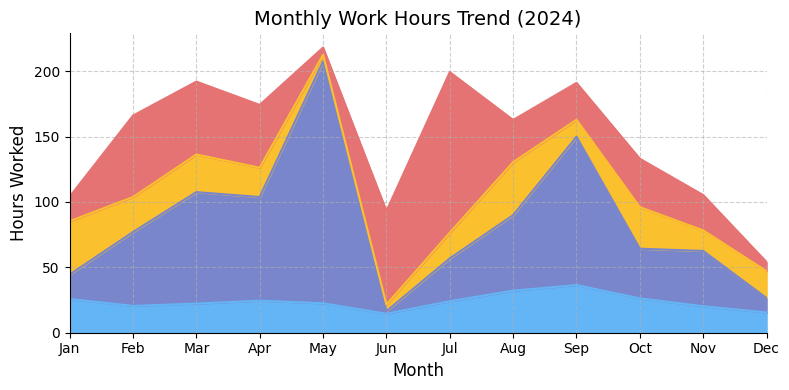

In [ ]:
# Filter out unexpected categories and retain only known ones
df_monthly = df_monthly.loc[:, df_monthly.columns.intersection(category_colors.keys())]

# Assign colors only to valid categories
colors = [category_colors[c] for c in df_monthly.columns]

# Plot the stacked area chart
fig, ax = plt.subplots(figsize=(8, 4))

df_monthly.plot(kind="area", stacked=True, color=colors, ax=ax)

ax.set_title("Monthly Work Hours Trend (2024)", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Hours Worked", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)

# Remove top and right spines for a cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set x-axis limits from January to December
ax.set_xlim(left=0, right=11)
ax.set_xticks(range(12))
ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

# Remove legend
ax.legend().set_visible(False)

plt.tight_layout()
plt.show()





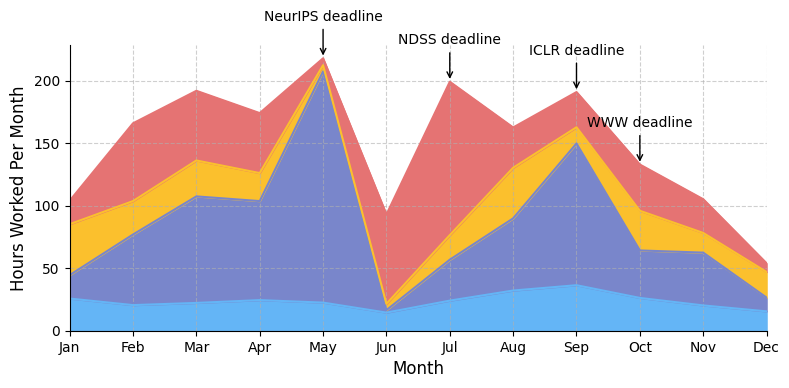

In [30]:
# add following arrow: 
# NeurIPS deadline: May
# NDSS deadline: July
# ICLR deadline: Sep
# WWW deadline: Oct

# Define the months corresponding to deadlines
deadlines = {
    "NeurIPS deadline": 4,  # May (0-based index)
    "NDSS deadline": 6,  # July
    "ICLR deadline": 8,  # September
    "WWW deadline": 9,  # October
}

# Replot the existing chart
fig, ax = plt.subplots(figsize=(8, 4))

df_monthly.plot(kind="area", stacked=True, color=colors, ax=ax)

# ax.set_title("Monthly Work Hours Trend (2024)", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Hours Worked Per Month", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)

# Remove top and right spines for a cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set x-axis limits from January to December
ax.set_xlim(left=0, right=11)
ax.set_xticks(range(12))
ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

# Remove legend
ax.legend().set_visible(False)

# Add arrows pointing to peaks corresponding to deadlines
for label, month in deadlines.items():
    max_y = df_monthly.iloc[month].sum()  # Get the peak value for the month
    ax.annotate(label, xy=(month, max_y), xytext=(month, max_y + 30),
                arrowprops=dict(facecolor='black', arrowstyle='->'), ha='center', fontsize=10)

plt.tight_layout()
# save as png
plt.savefig("imgs/monthly_work_hours_trend.png", dpi=300)
plt.show()


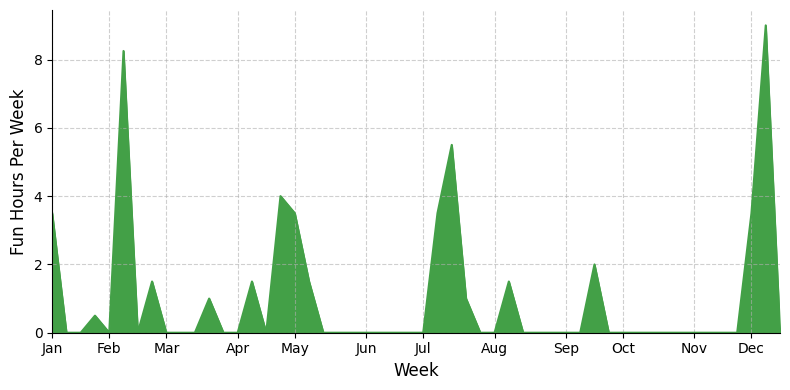

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

# Define the colors for the selected "outside-of-work" tasks
outside_colors = {
    "Fun Stuff": "#43A047",  # Green
    # "Exercise": "#8E24AA",  # Purple
}

# Convert type2weeks to DataFrame with weeks as index
df_weekly_outside = pd.DataFrame(type2weeks)

# Ensure only valid categories are included
df_weekly_outside = df_weekly_outside[[c for c in df_weekly_outside.columns if c in outside_colors]]

# Plot the stacked area chart with weekly data
fig, ax = plt.subplots(figsize=(8, 4))

df_weekly_outside.plot(kind="area", stacked=True, color=[outside_colors[c] for c in df_weekly_outside.columns], ax=ax)

#ax.set_title("Weekly Outside-of-Work Hours Trend (2024)", fontsize=14)
ax.set_xlabel("Week", fontsize=12)
ax.set_ylabel("Fun Hours Per Week", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)

# Remove top and right spines for a cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Define week-based x-axis with monthly labels
weeks_per_month = [4, 4, 5, 4, 5, 4, 5, 5, 4, 5, 4, 5]
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month_ticks = np.cumsum([0] + weeks_per_month[:-1])  # Position ticks at the start of each month

ax.set_xticks(month_ticks)
ax.set_xticklabels(month_labels)
ax.set_xlim(left=0, right=51)

# Remove legend for a cleaner plot
ax.legend().set_visible(False)

plt.tight_layout()
plt.savefig("imgs/weekly_fun_hours_trend.png", dpi=300)
plt.show()


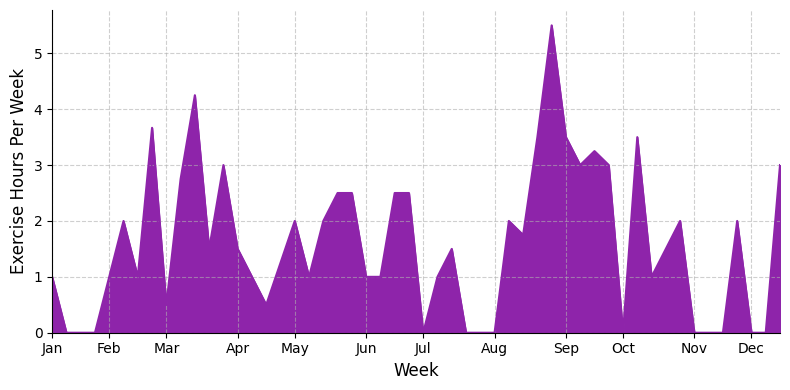

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

# Define the colors for the selected "outside-of-work" tasks
outside_colors = {
    "Exercise": "#8E24AA",  # Purple
}

# Convert type2weeks to DataFrame with weeks as index
df_weekly_outside = pd.DataFrame(type2weeks)

# Ensure only valid categories are included
df_weekly_outside = df_weekly_outside[[c for c in df_weekly_outside.columns if c in outside_colors]]

# Plot the stacked area chart with weekly data
fig, ax = plt.subplots(figsize=(8, 4))

df_weekly_outside.plot(kind="area", stacked=True, color=[outside_colors[c] for c in df_weekly_outside.columns], ax=ax)

# ax.set_title("Weekly Outside-of-Work Hours Trend (2024)", fontsize=14)
ax.set_xlabel("Week", fontsize=12)
ax.set_ylabel("Exercise Hours Per Week", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)

# Remove top and right spines for a cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Define week-based x-axis with monthly labels
weeks_per_month = [4, 4, 5, 4, 5, 4, 5, 5, 4, 5, 4, 5]
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month_ticks = np.cumsum([0] + weeks_per_month[:-1])  # Position ticks at the start of each month

ax.set_xticks(month_ticks)
ax.set_xticklabels(month_labels)
ax.set_xlim(left=0, right=51)

# Remove legend for a cleaner plot
ax.legend().set_visible(False)

plt.tight_layout()
plt.savefig("imgs/weekly_exercise_hours_trend.png", dpi=300)
plt.show()


## Projects

## Terms Project




In [73]:
type2weeks_term_project = defaultdict(lambda: [0] * 52)  # 52 weeks in a year

for color, color_events in color2events.items():
    event_type = color2type.get(color, 'Others')  # Get event type or default to Others
    
    for event in color_events:
        try:
            if any(keyword in event['summary'].lower() for keyword in ['terms', 'term', 'ndss', 'www', 't&c']):
                print(event['summary'])
                # Convert to EDT if not already
                start_tz = pytz.timezone(event['start'].get('timeZone', 'America/Detroit'))
                end_tz = pytz.timezone(event['end'].get('timeZone', 'America/Detroit')) 
                edt_tz = pytz.timezone('America/Detroit')
                
                start_dt = datetime.fromisoformat(event['start'].get('dateTime'))
                end_dt = datetime.fromisoformat(event['end'].get('dateTime'))
                
                if start_tz != edt_tz:
                    start_dt = start_tz.localize(start_dt).astimezone(edt_tz)
                if end_tz != edt_tz:
                    end_dt = end_tz.localize(end_dt).astimezone(edt_tz)
                    
                duration = (end_dt - start_dt).total_seconds() / 3600
                
                week_num = start_dt.isocalendar()[1] - 1  # isocalendar week starts at 1
                
                if duration < 10:  
                    type2weeks_term_project[event_type][week_num] += duration
                
        except:
            continue


NDSS
NDSS student verification
NDSS travel stuff
WWW review
WWW review
stupid WWW review
[NDSS'24 Summer] Prudential & Upcoming early-bird registration and student support application deadlines
T&C project explore
T&C reopen
T&C project roadmap and overleaf
Workshop paper TermLens
TermLens Workshop paper
TermLens Workshop paper
T&C workshop paper
T&C workshop paper
T&C project rehash
T&C workshop paper 
NDSS registration and UM Travel Grant
NDSS registration and UM Travel Grant
T&C scripts
T&C pipeline
T&C pipeline
T&C projects
T&C project coding
T&C paper explore
T&C project
Elisa Weekly meeting (T&C project)
NDSS talk prep
NDSS presentation
NDSS talk prep
NDSS talk prep
NDSS presentation slides
Elisa NDSS slides meeting
NDSS slides
NDSS presentation upload deadline
NDSS slides prep
T&C project w Neal
upload NDSS slides
T&C dataset sanitization and annotation
T&C project chat with Neal Rag optimization
T&C project
Elisa Weekly meeting (T&C project)
NDSS slides prep
NDSS Session 1B: Ce

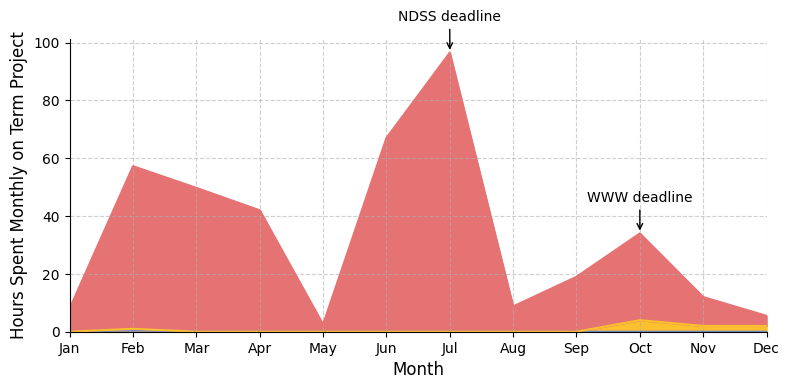

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# Define the months corresponding to deadlines
deadlines = {
    "NDSS deadline": 7,  # July
    "WWW deadline": 10,  # October
}

# Define colors for the three categories
term_project_colors = {
    "Important and Not Urgent": "#7986CB",  # Blue
    "Not Important and Urgent": "#FBC02D",  # Yellow
    "Important and Urgent": "#E57373",  # Red
}

# Approximate number of weeks per month in 2024
weeks_per_month = [4, 4, 5, 4, 5, 4, 5, 5, 4, 5, 4, 5]

# Convert weekly data to monthly totals
type2months_term_project = defaultdict(lambda: [0] * 12)

for category, weekly_hours in type2weeks_term_project.items():
    month_index = 0
    week_counter = 0
    for week_hours in weekly_hours:
        type2months_term_project[category][month_index] += week_hours
        week_counter += 1
        if week_counter == weeks_per_month[month_index]:  # Move to next month
            month_index += 1
            week_counter = 0

# Convert to DataFrame
df_monthly_term_project = pd.DataFrame(type2months_term_project, index=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
])

# Ensure only known categories are included
df_monthly_term_project = df_monthly_term_project.loc[:, df_monthly_term_project.columns.intersection(term_project_colors.keys())]

# Assign colors only to valid categories
colors_term_project = [term_project_colors[c] for c in df_monthly_term_project.columns]

# Plot the stacked area chart
fig, ax = plt.subplots(figsize=(8, 4))

df_monthly_term_project.plot(kind="area", stacked=True, color=colors_term_project, ax=ax)

# ax.set_title("Monthly Time Spent on Term Project (2024)", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Hours Spent Monthly on Term Project", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)

# Remove top and right spines for a cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set x-axis labels for months
ax.set_xticks(range(12))
ax.set_xlim(left=0, right=11)
ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

# Add arrows pointing to peaks corresponding to deadlines
# Add annotations for key deadlines


# Add deadline annotations
for deadline_name, month in deadlines.items():
    ax.annotate(
        deadline_name,
        xy=(month-1, df_monthly_term_project.iloc[month-1].sum()),
        xytext=(month-1, df_monthly_term_project.iloc[month-1].sum() + 10),
        ha='center',
        va='bottom',
        arrowprops=dict(arrowstyle='->', color='black', lw=1)
    )



# Show legend for clarity
ax.legend().set_visible(False)
plt.tight_layout()
plt.savefig("imgs/monthly_term_project.png", dpi=300)
plt.show()



In [47]:
type2weeks_term_project.keys()

dict_keys(['Important and Not Urgent', 'Not Important and Urgent', 'Important and Urgent'])

## Data Efficiency Project

In [65]:
type2weeks_elfs_project = defaultdict(lambda: [0] * 52)  # 52 weeks in a year

for color, color_events in color2events.items():
    event_type = color2type.get(color, 'Others')  # Get event type or default to Others
    
    for event in color_events:
        try:
            if any(keyword in event['summary'].lower() for keyword in ['elfs', 'label', 'data', 'efficiency', 'neurips', 'iclr']):
                print(event['summary'])
                # Convert to EDT if not already
                start_tz = pytz.timezone(event['start'].get('timeZone', 'America/Detroit'))
                end_tz = pytz.timezone(event['end'].get('timeZone', 'America/Detroit')) 
                edt_tz = pytz.timezone('America/Detroit')
                
                start_dt = datetime.fromisoformat(event['start'].get('dateTime'))
                end_dt = datetime.fromisoformat(event['end'].get('dateTime'))
                
                if start_tz != edt_tz:
                    start_dt = start_tz.localize(start_dt).astimezone(edt_tz)
                if end_tz != edt_tz:
                    end_dt = end_tz.localize(end_dt).astimezone(edt_tz)
                    
                duration = (end_dt - start_dt).total_seconds() / 3600
                
                week_num = start_dt.isocalendar()[1] - 1  # isocalendar week starts at 1
                
                if duration < 10:  
                    type2weeks_elfs_project[event_type][week_num] += duration
                
        except:
            continue


data efficiency
label free
label free
label free code understanding
label free and ICML review
Label free
Label free
Label free
label free
label free: move dir and visualize
label free
label free
label free 
label, label free
label free
label free slides prep
label free
label free aum check
label free!
label free
label free
label free
label free
label free
label free
NLU label free
NLU label free and new sampling method test
Label free a lot of experiments
UMich | Cisco Research Project Update #1 "On the Data Efficiency of LLMs Fine-Tuning with RLHF"
Imagenet pseudo labels
label free
label free
label free imagenet error
label free
label free
label free
label free
label free - documentation and pseudo label generation code
label free
label free: imagenet visualization
label free NLU
NLU label free
NLU label free
label free check
label free
label free
label free
label free
label free
label free ablation studies
label free fine tuning with lang
Label free? NLU
Label free
Label freeee
labe

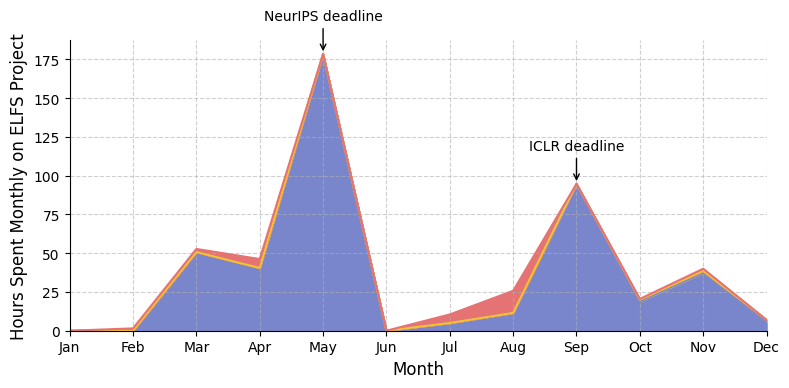

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# Define the months corresponding to deadlines
deadlines = {
    "NeurIPS deadline": 5,  
    "ICLR deadline": 9, 
}

# Define colors for the three categories
elfs_project_colors = {
    "Important and Not Urgent": "#7986CB",  # Blue
    "Not Important and Urgent": "#FBC02D",  # Yellow
    "Important and Urgent": "#E57373",  # Red
}

# Approximate number of weeks per month in 2024
weeks_per_month = [4, 4, 5, 4, 5, 4, 5, 5, 4, 5, 4, 5]

# Convert weekly data to monthly totals
type2months_elfs_project = defaultdict(lambda: [0] * 12)

for category, weekly_hours in type2weeks_elfs_project.items():
    month_index = 0
    week_counter = 0
    for week_hours in weekly_hours:
        type2months_elfs_project[category][month_index] += week_hours
        week_counter += 1
        if week_counter == weeks_per_month[month_index]:  # Move to next month
            month_index += 1
            week_counter = 0

# Convert to DataFrame
df_monthly_elfs_project = pd.DataFrame(type2months_elfs_project, index=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
])

# Ensure only known categories are included
df_monthly_elfs_project = df_monthly_elfs_project.loc[:, df_monthly_elfs_project.columns.intersection(elfs_project_colors.keys())]

# Assign colors only to valid categories
colors_elfs_project = [elfs_project_colors[c] for c in df_monthly_elfs_project.columns]

# Plot the stacked area chart
fig, ax = plt.subplots(figsize=(8, 4))

df_monthly_elfs_project.plot(kind="area", stacked=True, color=colors_elfs_project, ax=ax)

ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Hours Spent Monthly on ELFS Project", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)

# Remove top and right spines for a cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set x-axis labels for months
ax.set_xticks(range(12))
ax.set_xlim(left=0, right=11)
ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

# Add arrows pointing to peaks corresponding to deadlines
# Add annotations for key deadlines


# Add deadline annotations
for deadline_name, month in deadlines.items():
    ax.annotate(
        deadline_name,
        xy=(month-1, df_monthly_elfs_project.iloc[month-1].sum()),
        xytext=(month-1, df_monthly_elfs_project.iloc[month-1].sum() + 20),
        ha='center',
        va='bottom',
        arrowprops=dict(arrowstyle='->', color='black', lw=1)
    )



# Show legend for clarity
ax.legend().set_visible(False)
plt.tight_layout()
plt.savefig("imgs/monthly_elfs_project.png", dpi=300)
plt.show()



## Word Cloud

In [139]:
event_titles = []
for color, color_events in color2events.items():
    event_titles.extend([event.get('summary', '') for event in color_events])
    
# filter out empty strings
event_titles = [title.lower() for title in event_titles if title]

# filter out the following strings
filtered_word = ['math 214 evening', 'writing time', 'elisa time!!', 'duolingo']
event_titles = [title for title in event_titles if not any(word in title for word in filtered_word)]

In [155]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re


event_titles_merged = " ".join(event_titles)

# Generate the word cloud
wordcloud = WordCloud(
    width=800, height=400,
    background_color="white",
    colormap="viridis",
    max_words=100
).generate(event_titles_merged)



In [156]:
for word in wordcloud.words_:
    if 'project' in word:
        print(word)

language project
c project
project language
phone project
project weekly
terms project


In [157]:
words = wordcloud.words_

# change terms project name

if 't c' in words and 'c t' in words:
    print('t c and c t')
    combined_frequency = words['t c']+words['c t']+words['c project']+words['terms project']
    

    words['Terms and Conditions'] = combined_frequency
    
    del words['t c']
    del words['c t']
    del words['c project']
    del words['terms project']

# change meeting with name to project name
if 'haizhong meeting' and 'elisa haizhong' and 'free label' in words:
    words['label free'] = words['haizhong meeting'] + words['elisa haizhong'] + words['free label'] + words['language project'] + words['label free']
    del words['haizhong meeting']
    del words['elisa haizhong']
    del words['free label']


wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(words)


t c and c t


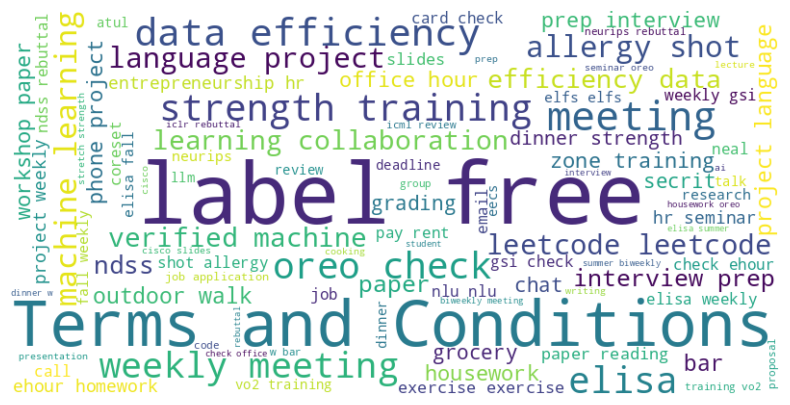

In [158]:
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axis labels
# plt.title("Google Calendar Event Word Cloud (2024)", fontsize=14)
plt.savefig("imgs/wordcloud.png", dpi=300)
plt.show()
